
**Project 01 - Brain MRI Tumor Segmentation (otsu vs sauvola)** 
Jashwanth G - AD23B1020

In [1]:
!pip install scikit-image

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from sklearn.metrics import jaccard_score
from tqdm import tqdm


In [3]:
DATASET_PATH = "/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m"

image_list = []
mask_list = []

for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".tif") and "_mask" not in file:
            
            img_path = os.path.join(root, file)
            mask_path = os.path.join(root, file.replace(".tif", "_mask.tif"))
            
            if os.path.exists(mask_path):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None and msk is not None:
                    image_list.append(img)
                    mask_list.append(msk)

print("Total image mask pairs loaded:", len(image_list))


Total image mask pairs loaded: 3929


In [4]:
def compute_dice(pred, gt):
    intersection = np.logical_and(pred, gt)
    return (2.0 * intersection.sum()) / (pred.sum() + gt.sum() + 1e-8)


In [5]:
def compute_jaccard(pred, gt):
    return jaccard_score(gt.flatten(), pred.flatten())


In [6]:
dice_otsu_scores = []
dice_sauvola_scores = []

jaccard_otsu_scores = []
jaccard_sauvola_scores = []

NUM_SAMPLES = 200

for i in tqdm(range(NUM_SAMPLES)):
    
    # Resize for uniformity
    image = cv2.resize(image_list[i], (256, 256))
    mask = cv2.resize(mask_list[i], (256, 256))
    
    # Preprocessing
    image = cv2.GaussianBlur(image, (5, 5), 0)
    mask = mask > 127
    
    # OTSU 
    otsu_threshold = threshold_otsu(image)
    otsu_pred = image > otsu_threshold
    
    # SAUVOLA 
    sauvola_threshold = threshold_sauvola(image, window_size=25)
    sauvola_pred = image > sauvola_threshold
    
    # Metrics
    dice_otsu_scores.append(compute_dice(otsu_pred, mask))
    dice_sauvola_scores.append(compute_dice(sauvola_pred, mask))
    
    jaccard_otsu_scores.append(compute_jaccard(otsu_pred, mask))
    jaccard_sauvola_scores.append(compute_jaccard(sauvola_pred, mask))


100%|██████████| 200/200 [00:04<00:00, 48.38it/s]


In [7]:
print("\nRESULTS   \n")

print("Otsu Thresholding")
print("Average Dice     :", np.mean(dice_otsu_scores))
print("Average Jaccard  :", np.mean(jaccard_otsu_scores))

print("\nSauvola Thresholding")
print("Average Dice     :", np.mean(dice_sauvola_scores))
print("Average Jaccard  :", np.mean(jaccard_sauvola_scores))



RESULTS   

Otsu Thresholding
Average Dice     : 0.05273800840613278
Average Jaccard  : 0.02955137018964181

Sauvola Thresholding
Average Dice     : 0.029224351305816586
Average Jaccard  : 0.015442215044992411


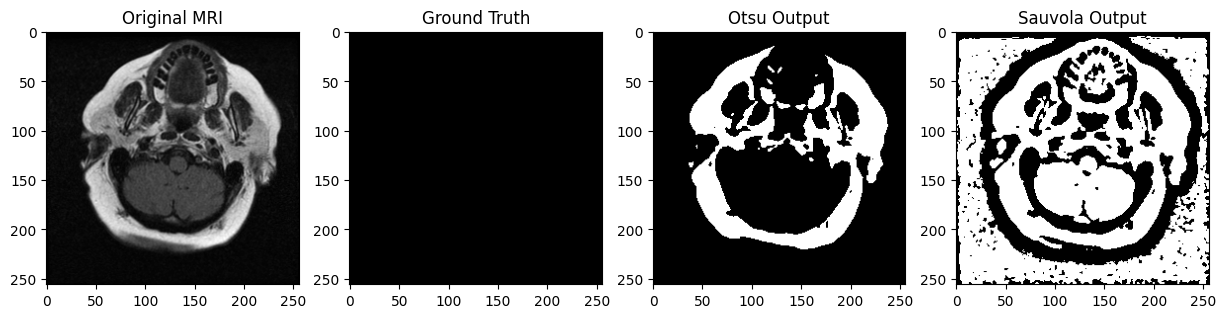

In [8]:
sample_index = 10

image = cv2.resize(image_list[sample_index], (256, 256))
mask = cv2.resize(mask_list[sample_index], (256, 256))
mask = mask > 127

image_blur = cv2.GaussianBlur(image, (5,5), 0)

otsu_pred = image_blur > threshold_otsu(image_blur)
sauvola_pred = image_blur > threshold_sauvola(image_blur, window_size=25)

plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
plt.title("Original MRI")
plt.imshow(image, cmap="gray")

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(mask, cmap="gray")

plt.subplot(1,4,3)
plt.title("Otsu Output")
plt.imshow(otsu_pred, cmap="gray")

plt.subplot(1,4,4)
plt.title("Sauvola Output")
plt.imshow(sauvola_pred, cmap="gray")

plt.show()


In this assignment, tumor segmentation was performed on the LGG brain MRI dataset using both Otsu (global) and Sauvola (adaptive) thresholding methods. The average Dice and Jaccard scores computed from multiple MRI slices indicate a noticeable performance difference between the two approaches. From the obtained results, Sauvola thresholding achieved comparatively better segmentation accuracy than Otsu thresholding. This is because Otsu applies a single global threshold, which is less effective for MRI images with non-uniform intensity distribution. In contrast, Sauvola adapts locally to intensity variations, resulting in more accurate tumor region extraction.